# Gap case 3

This notebook describes a test case with one ``Ingestion-Walltime-Us`` values gap of ~6 s.

The case is characterized by three small (< 0.1 s) ``Ingestion-Walltime-Us`` difference values, and two of the corresponding segments have the same ``Ingestion-Walltime-Us`` value. Also, these two segments are black while their duration is normal (~2 s). The video image returns back in the middle of the next segment after the "black screen" period.

The video segments are from *Webcam Zürich HB* live stream: https://www.youtube.com/watch?v=kHwmzef842g.

In [1]:
from datetime import datetime, timedelta, timezone
from itertools import groupby
from pathlib import Path
from zoneinfo import ZoneInfo

import numpy as np
import pandas as pd
import seaborn as sns
from brokenaxes import brokenaxes, BrokenAxes

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import patheffects
from matplotlib.collections import LineCollection
from matplotlib.ticker import MaxNLocator, MultipleLocator, FormatStrFormatter

from src.common import discrete_diff, interpolate_point
from src.display import display_first_video_frame, display_last_video_frame
from src.plotting import PlainOffsetScalarFormatter, plot_hat_graph, plot_ingestion_line

%load_ext autoreload
%autoreload 1

%aimport src.common
%aimport src.display
%aimport src.plotting

In [2]:
mpl.rcParams["axes.prop_cycle"] = mpl.cycler(color=mpl.cm.Set2.colors)
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

In [3]:
pd.set_option("display.float_format", "{:f}".format)

In [4]:
figure_dpi = 100
figure_size = (w := 640 / figure_dpi, w / 1.5)

In [5]:
SHARED_PATH = Path("./shared/")

In [6]:
SEGMENT_DURATION = 2.0
STREAM_TIMEZONE = ZoneInfo("Europe/Zurich")

## Loading data

In [7]:
data = pd.read_csv(
    SHARED_PATH / "gap-cases/3/gaps-case-3-i244-metadata.csv",
    usecols=["sequence","Ingestion-Walltime-Us","Stream-Duration-Us"]
)
data = data.set_index("sequence")
data /= 1e6

In [8]:
durations = pd.read_csv(
    SHARED_PATH / "gap-cases/3/gaps-case-3-i244-duration.csv",
    index_col="sequence"
)
data = pd.concat([data, durations], axis=1)
data = data.loc[:,~data.columns.duplicated()]

with pd.option_context("display.max_rows", 12):
    display(data)

,Ingestion-Walltime-Us,Stream-Duration-Us,duration
sequence,,,
7958083,1679785160.564784,15915760.272000,1.933000
7958084,1679785162.457230,15915762.272000,2.000000
7958085,1679785164.514560,15915764.339000,2.000000
7958086,1679785166.470007,15915766.339000,2.000000
7958087,1679785168.443859,15915768.272000,2.000000
...,...,...,...
7958119,1679785232.216697,15915831.672000,1.933000
7958120,1679785234.207527,15915833.605000,1.934000
7958121,1679785236.104288,15915835.539000,2.000000


## Plotting data

### Ingestion-Walltime-Us values

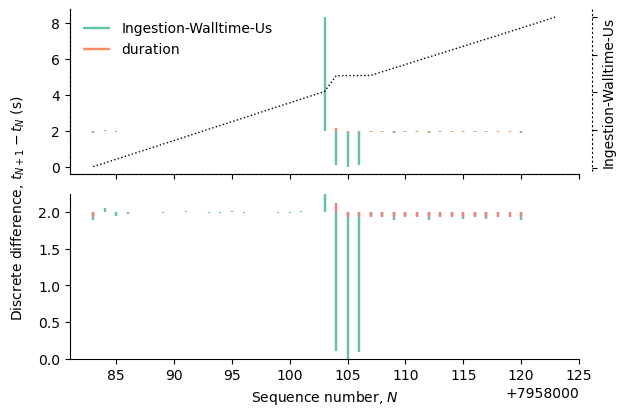

In [9]:
fig, axs = plt.subplots(2, 1, figsize=figure_size, dpi=figure_dpi, sharex=True, height_ratios=(1, 1)) 

ax, axb = axs


# Main axis
ax.vlines(
    x=data.index,
    ymin=2,
    ymax=discrete_diff(data["Ingestion-Walltime-Us"]),
    colors="C0",
    lw=1.75,
    label="Ingestion-Walltime-Us"
)
ax.vlines(
    x=data.index,
    ymin=2,
    ymax=data["duration"],
    colors="C1",
    lw=1.75,
    label="duration"
)

sns.despine(ax=ax)

# Secondary axis
ax2 = ax.twinx()

ax2.plot(data.index, data["Ingestion-Walltime-Us"], ls=":", c="k", lw=1)

ax2.tick_params(axis="y", which="both", right=True, labelright=False)
ax2.set_ylabel("Ingestion-Walltime-Us")

ax2.spines.right.set_position(("axes", 1.025))
sns.despine(ax=ax2, right=False)
for spine in ax2.spines.values():
    spine.set_linestyle((1, (1, 3)))

    
# Bottom axis
axb.vlines(
    x=data.index,
    ymin=2,
    ymax=discrete_diff(data["Ingestion-Walltime-Us"]),
    colors="C0",
    lw=1.75,
    label="Ingestion-Walltime-Us"
)

axb.vlines(
    x=data.index,
    ymin=2,
    ymax=data["duration"],
    colors="lightcoral",
    lw=1.75,
    label="(Actual duration)"
)

axb.xaxis.set_major_formatter(PlainOffsetScalarFormatter())
axb.set_ylim(0, 2.25)

sns.despine(ax=axb)


ax.legend(frameon=False, loc=2)

axb.set_xlabel("Sequence number, $N$")
fig.supylabel("Discrete difference, $t_{N + 1} - t_N$ (s)", fontsize=10, x=0.03)

plt.tight_layout()
plt.show()

## Narrow to the gap

In [10]:
pd.concat(
    [
        discrete_diff(data["Ingestion-Walltime-Us"]),
        data["duration"]
    ],
    axis=1
).loc[7958103:7958108]

,Ingestion-Walltime-Us,duration
sequence,,
7958103,8.347661,2.000000
7958104,0.105933,2.133000
7958105,0.000000,1.934000
7958106,0.090874,1.933000
7958107,1.943393,1.933000
7958108,1.950612,1.934000


In [11]:
gap_start_idx = discrete_diff(data["Ingestion-Walltime-Us"]).idxmax()
ingestion_diff_value = data.loc[gap_start_idx+1, "Ingestion-Walltime-Us"] - data.loc[gap_start_idx, "Ingestion-Walltime-Us"]
gap_length = ingestion_diff_value - data.loc[gap_start_idx, "duration"]
print(f"Gap length ({gap_start_idx}-{gap_start_idx + 1}): {gap_length:f} s")

Gap length (7958103-7958104): 6.347661 s


In [12]:
gap_data = data.loc[7958103-2:7958103+20]
gap_data

,Ingestion-Walltime-Us,Stream-Duration-Us,duration
sequence,,,
7958101,1679785196.440048,15915796.272000,2.000000
7958102,1679785198.452225,15915798.272000,2.000000
7958103,1679785200.449813,15915800.272000,2.000000
7958104,1679785208.797474,15915802.272000,2.133000
7958105,1679785208.903407,15915804.272000,1.934000
7958106,1679785208.903407,15915806.272000,1.933000
7958107,1679785208.994281,15915808.272000,1.933000
7958108,1679785210.937674,15915810.405000,1.934000
7958109,1679785212.888286,15915812.339000,1.933000


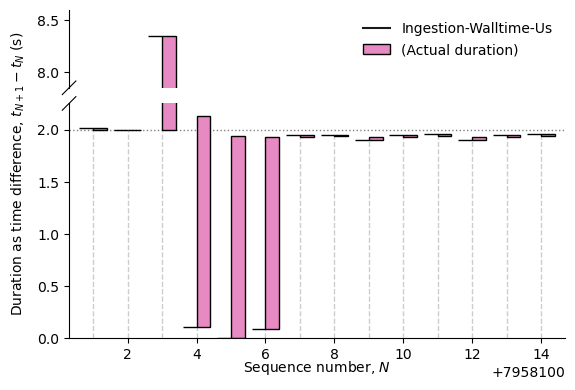

In [13]:
w, h = figure_size
fig = plt.figure(figsize=(w, h * 1), dpi=figure_dpi)

plot_data = gap_data.loc[7958101:7958115]

max_ingestion_diff_value = discrete_diff(plot_data["Ingestion-Walltime-Us"]).max()
ylims = [
    (-0, 2.25),
    (max_ingestion_diff_value - 0.5, max_ingestion_diff_value + 0.25)
]

bax = brokenaxes(ylims=ylims, hspace=0.1, tilt=45)

y1, y2 = discrete_diff(plot_data["Ingestion-Walltime-Us"]), plot_data["duration"]
plot_hat_graph(bax, sequences=plot_data.index, y1=y1, y2=y2, baseline=SEGMENT_DURATION, width=0.2)

bax.axs[1].vlines(plot_data.index, ymin=0, ymax=y1.fillna(0), lw=1, ls="--", colors="0.8", zorder=0)

plt.show()

### Test points

In [14]:
y_S2 = gap_data.loc[7958103]["Ingestion-Walltime-Us"] + gap_data.loc[7958103+1]["duration"] / 2

points_list = [
    ("S_1", interpolate_point(7958102.5, gap_data.index, gap_data["Ingestion-Walltime-Us"])),
    ("S_2", interpolate_point(y_S2, gap_data["Ingestion-Walltime-Us"], gap_data.index)[::-1]),
    ("S_3/E_3", interpolate_point(7958103.5, gap_data.index, gap_data["Ingestion-Walltime-Us"])),
    ("S_4", interpolate_point(7958104.5, gap_data.index, gap_data["Ingestion-Walltime-Us"])),
    ("S_5", interpolate_point(7958105, gap_data.index, gap_data["Ingestion-Walltime-Us"])),
    ("S_5", interpolate_point(7958106, gap_data.index, gap_data["Ingestion-Walltime-Us"])),
]

for label, point in points_list:
    print("{:>14}".format(f"Point {label}:"), f"segment {int(point[0])}, {point[1]:.6f}")

    Point S_1: segment 7958102, 1679785199.451019
    Point S_2: segment 7958103, 1679785201.516313
Point S_3/E_3: segment 7958103, 1679785204.623643
    Point S_4: segment 7958104, 1679785208.850441
    Point S_5: segment 7958105, 1679785208.903407
    Point S_5: segment 7958106, 1679785208.903407


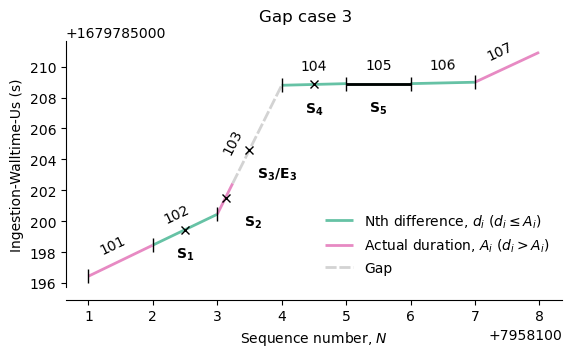

    Point S_1: segment 7958102, 1679785199.451019
    Point S_2: segment 7958103, 1679785201.516313
Point S_3/E_3: segment 7958103, 1679785204.623643
    Point S_4: segment 7958104, 1679785208.850441
    Point S_5: segment 7958105, 1679785208.903407
    Point S_5: segment 7958106, 1679785208.903407


In [15]:
w, h = figure_size

fig, ax = plt.subplots(1, 1, figsize=(w, h * 0.75), dpi=figure_dpi) 

plot_data = gap_data.loc[7958103-2:7958103+5]

plot_ingestion_line(ax, plot_data, color="lightcoral")

for label, point in points_list:
    if label == "S_5":
        continue
        
    match label:
        case "S_2":
            xytext = (20, -20)
        case "S_3/E_3":
            xytext = (20, -20)
        case _:
            xytext = (0, -20)
            
    ax.plot(*point, marker="x", color="none", mec="k", ms=6, mew=1)
    ax.annotate(f"$\mathbf{{{label}}}$", point, xytext=xytext, textcoords="offset points", ha="center")
    
# Annotate S_5 point:
ax.plot([7958105, 7958106], gap_data.loc[7958105:7958106, "Ingestion-Walltime-Us"], "k", lw=2, solid_capstyle="butt")
ax.annotate(f"$\mathbf{{S_5}}$", (7958105.5, gap_data.loc[7958105, "Ingestion-Walltime-Us"]), xytext=(0, -20), textcoords="offset points", ha="center")
         
plt.legend(frameon=False, loc=4)

fig.suptitle("Gap case 3")

plt.show()

for label, point in points_list:
    print("{:>14}".format(f"Point {label}:"), f"segment {int(point[0])}, {point[1]:.6f}")

In [16]:
timeline_data = pd.read_csv(SHARED_PATH / "gap-cases/3/gaps-case-3-i244-timeline.csv", index_col="sequence")
timeline_data.loc[7958103:7958109]

,d,yt:sid
sequence,,
7958103,2000,NaN
7958104,2132,5869.000000
7958105,1934,-1081.000000
7958106,1932,-1934.000000
7958107,1932,-1836.000000
7958108,1934,NaN
7958109,1932,NaN


### Selected video frames

Segment 7958103


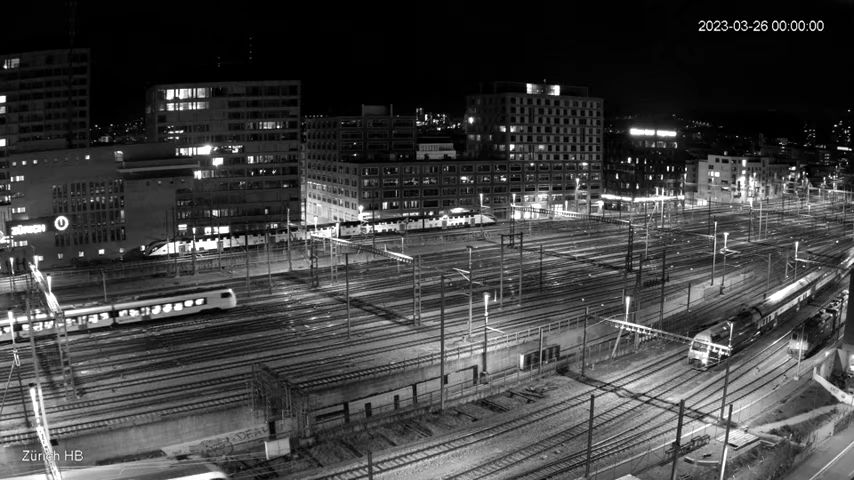

Ingestion-Walltime-Us: 2023-03-26 00:00:00.449813+01:00


In [17]:
sequence = 7958103
print(f"Segment {sequence}")
display_first_video_frame(SHARED_PATH / f"gap-cases/3/zur-{sequence}-i244.webm", format="gray")
print(
    "Ingestion-Walltime-Us:",
    datetime.fromtimestamp(gap_data.loc[sequence]["Ingestion-Walltime-Us"], tz=STREAM_TIMEZONE)
)

Segment 7958104
First frame:


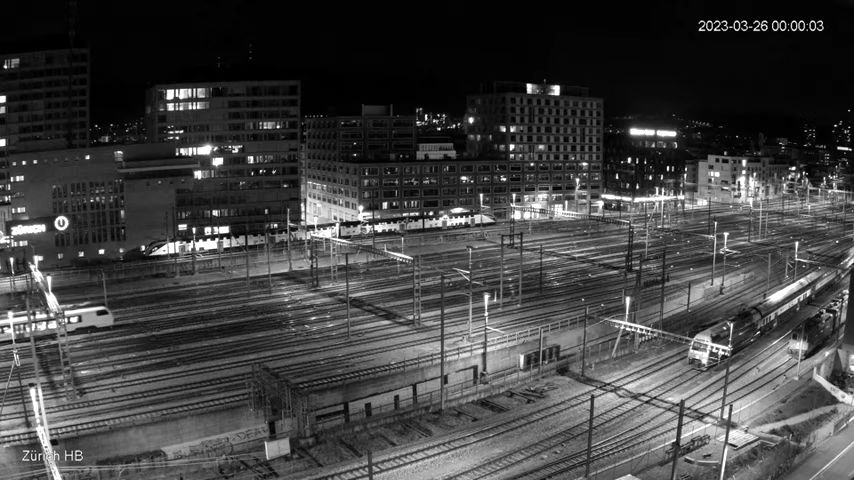

Ingestion-Walltime-Us: 2023-03-26 00:00:08.797474+01:00

Last frame:


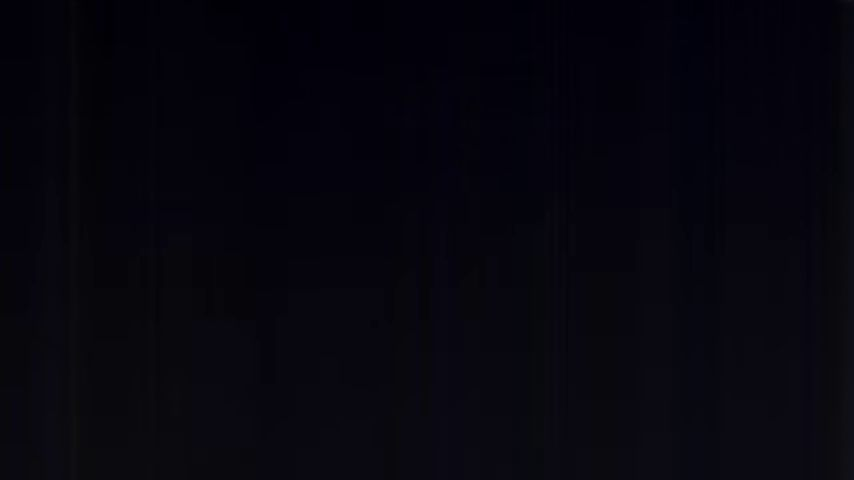

In [18]:
sequence = 7958104
print(f"Segment {sequence}")

segment_path = SHARED_PATH / f"gap-cases/3/zur-{sequence}-i244.webm"
print("First frame:")
display_first_video_frame(segment_path, format="gray")
print(
    "Ingestion-Walltime-Us:",
    datetime.fromtimestamp(gap_data.loc[sequence]["Ingestion-Walltime-Us"], tz=STREAM_TIMEZONE)
)

print()
print("Last frame:")
display_last_video_frame(segment_path)

Segment 7958107
First frame:


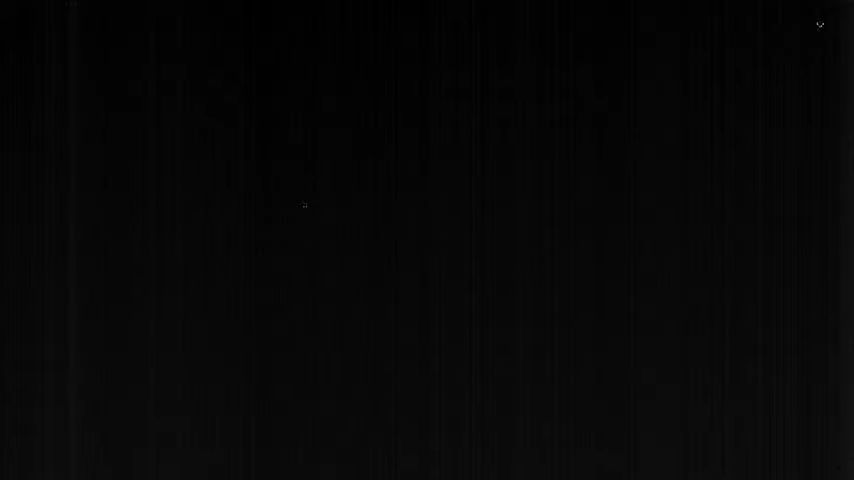

Ingestion-Walltime-Us: 2023-03-26 00:00:08.994281+01:00

Last frame:


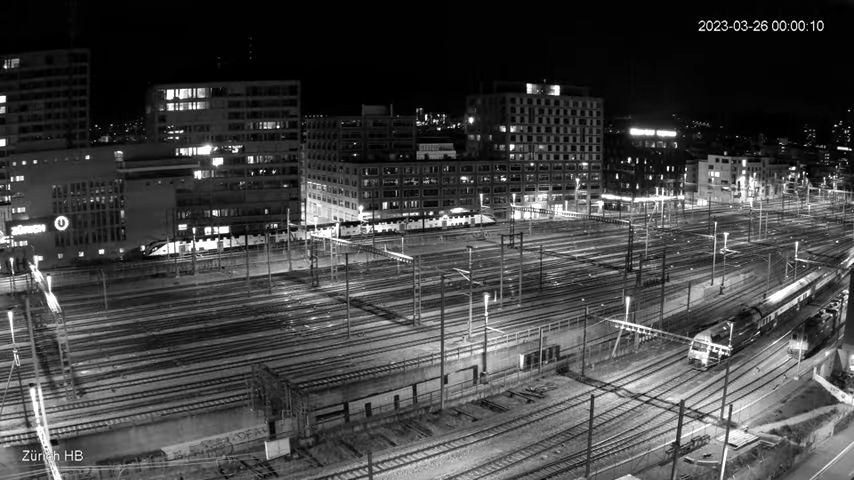

In [19]:
sequence = 7958107
print(f"Segment {sequence}")

segment_path = SHARED_PATH / f"gap-cases/3/zur-{sequence}-i244.webm"
print("First frame:")
display_first_video_frame(segment_path, format="gray")
print(
    "Ingestion-Walltime-Us:",
    datetime.fromtimestamp(gap_data.loc[sequence]["Ingestion-Walltime-Us"], tz=STREAM_TIMEZONE)
)

print()
print("Last frame:")
display_last_video_frame(segment_path, format="gray")

Segment 7958108


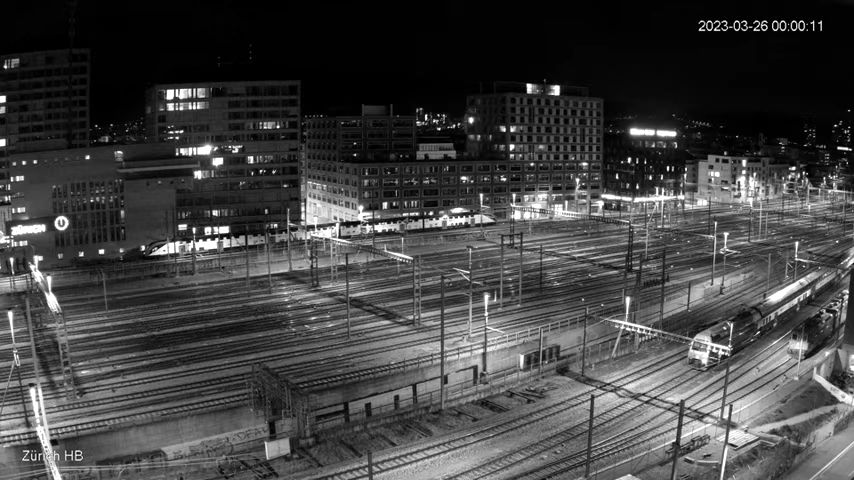

Ingestion-Walltime-Us: 2023-03-26 00:00:10.937674+01:00


In [20]:
sequence = 7958108
print(f"Segment {sequence}")
display_first_video_frame(SHARED_PATH / f"gap-cases/3/zur-{sequence}-i244.webm", format="gray")
print(
    "Ingestion-Walltime-Us:",
    datetime.fromtimestamp(gap_data.loc[sequence]["Ingestion-Walltime-Us"], tz=STREAM_TIMEZONE)
)

### Exporting fixture data

In [21]:
S = slice(7958090, 7958122)

to_export = data.loc[S][["Ingestion-Walltime-Us", "duration"]].copy()
to_export["Ingestion-Walltime-Us"] = to_export["Ingestion-Walltime-Us"].apply(lambda x: int(x * 1e6)) 

output_path = Path("./out/gap-cases/gap-case-3-fixture.csv")
output_path.parent.mkdir(parents=True, exist_ok=True)

to_export.to_csv(output_path)
with pd.option_context("display.max_rows", 8):
    display(to_export)

,Ingestion-Walltime-Us,duration
sequence,,
7958090,1679785174439922,2.000000
7958091,1679785176437344,2.000000
7958092,1679785178448072,2.000000
7958093,1679785180446691,2.000000
...,...,...
7958119,1679785232216697,1.933000
7958120,1679785234207527,1.934000
7958121,1679785236104288,2.000000
7958122,1679785238110449,2.000000
